In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
import pickle

In [36]:
df = pd.read_csv('Static_dataset.csv')

# Analysing the Data

In [3]:
df.head(10)

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
5,16:29.5,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
6,26:58.3,23,3,0,20,0,3.568087,3,3,16,7.000000,pforzheim,pforzheim-bisons,20,1,0
7,57:29.2,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
8,27:59.6,14,3,0,12,0,2.514247,2,3,6,4.000000,face,reface,10,1,0
9,21:27.9,18,0,0,17,0,2.879113,1,2,14,8.500000,store,dellogliostore,15,0,0


# Check the Data Imbalance

/tmp/ipykernel_18848/65638739.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


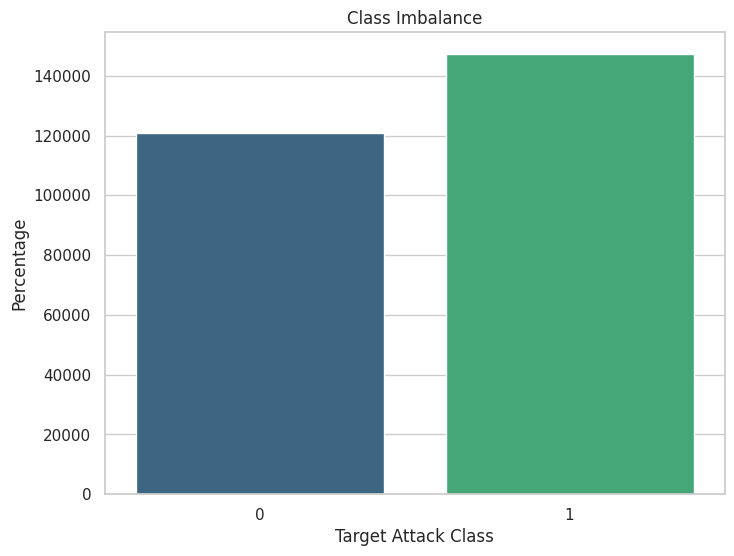

In [4]:
target_counts = df['Target Attack'].value_counts()

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title('Class Imbalance')
plt.xlabel('Target Attack Class')
plt.ylabel('Percentage')
plt.savefig('class_imbalance_plot.png')
plt.show()


# Data Distributions

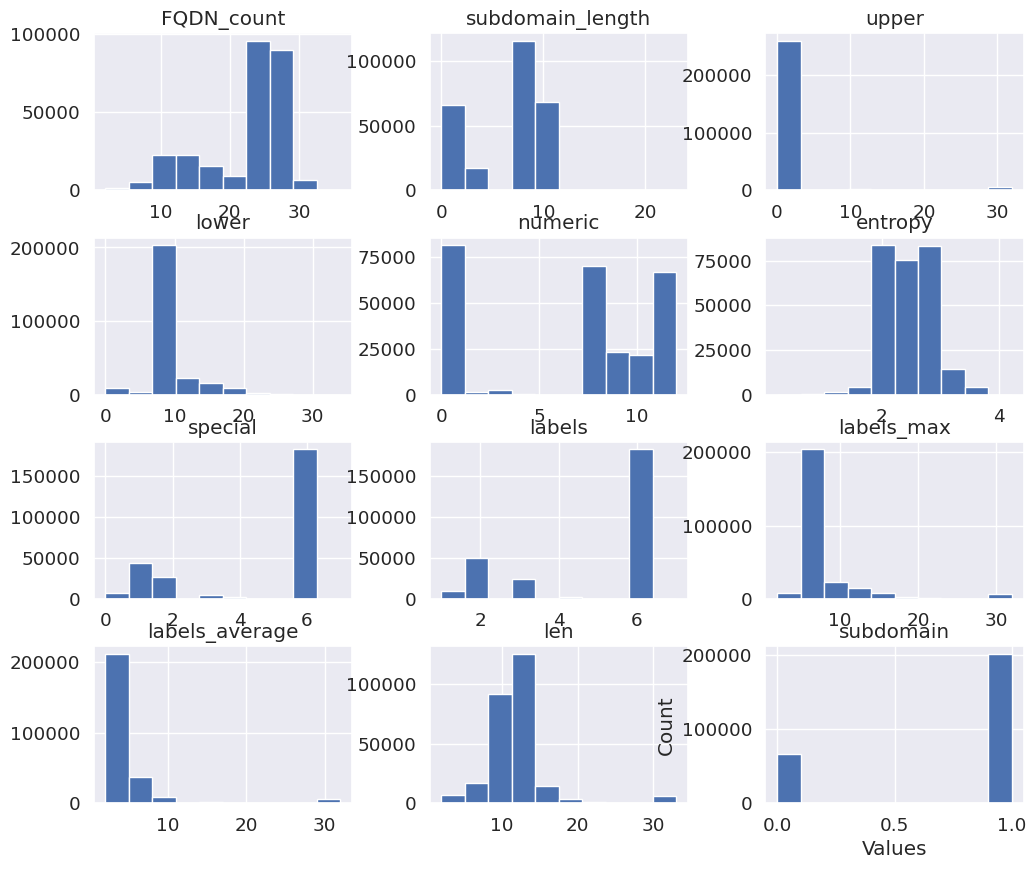

In [37]:
df.drop(columns=['Target Attack']).hist(figsize=(12, 10))
plt.xlabel('Values')
plt.ylabel('Count')
plt.show()


# Check the data statistics

In [6]:
df.describe()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497,0.549024
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975,0.497592
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000,1.000000


# Find Categorical Features

In [38]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

both_cols = []
for col in df.columns:
    is_numeric_column = df[col].apply(is_numeric)
    contains_both = is_numeric_column.any() and not is_numeric_column.all()
    
    if contains_both:
        both_cols.append(col)
        print("The column "+ col + " contains both numeric and categorical values.")
        
print(both_cols)


The column longest_word contains both numeric and categorical values.
The column sld contains both numeric and categorical values.
['longest_word', 'sld']


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

# Hash Categorical Features

In [40]:
def hash_categorical_value(value, num_buckets):
    return hash(value) % num_buckets
for col in both_cols:
    num_buckets = df[col].nunique()
    df[col] = df[col].apply(lambda x: hash_categorical_value(x, num_buckets))


# Handle Timestamp

In [41]:
df[['Minutes', 'Seconds']] = df['timestamp'].str.split(':', expand=True)
df['Minutes'] = df['Minutes'].astype(int)
df['Seconds'] = df['Seconds'].astype(float)
df['Total_Seconds'] = df['Minutes'] * 60 + df['Seconds']


scaler = MinMaxScaler()
df[['Total_Seconds']] = scaler.fit_transform(df[['Total_Seconds']])

df = df.drop(columns=['timestamp','Minutes', 'Seconds'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FQDN_count        268074 non-null  int64  
 1   subdomain_length  268074 non-null  int64  
 2   upper             268074 non-null  int64  
 3   lower             268074 non-null  int64  
 4   numeric           268074 non-null  int64  
 5   entropy           268074 non-null  float64
 6   special           268074 non-null  int64  
 7   labels            268074 non-null  int64  
 8   labels_max        268074 non-null  int64  
 9   labels_average    268074 non-null  float64
 10  longest_word      268074 non-null  int64  
 11  sld               268074 non-null  int64  
 12  len               268074 non-null  int64  
 13  subdomain         268074 non-null  int64  
 14  Target Attack     268074 non-null  int64  
 15  Total_Seconds     268074 non-null  float64
dtypes: float64(3), int64

# Chcek the Skewness of Data

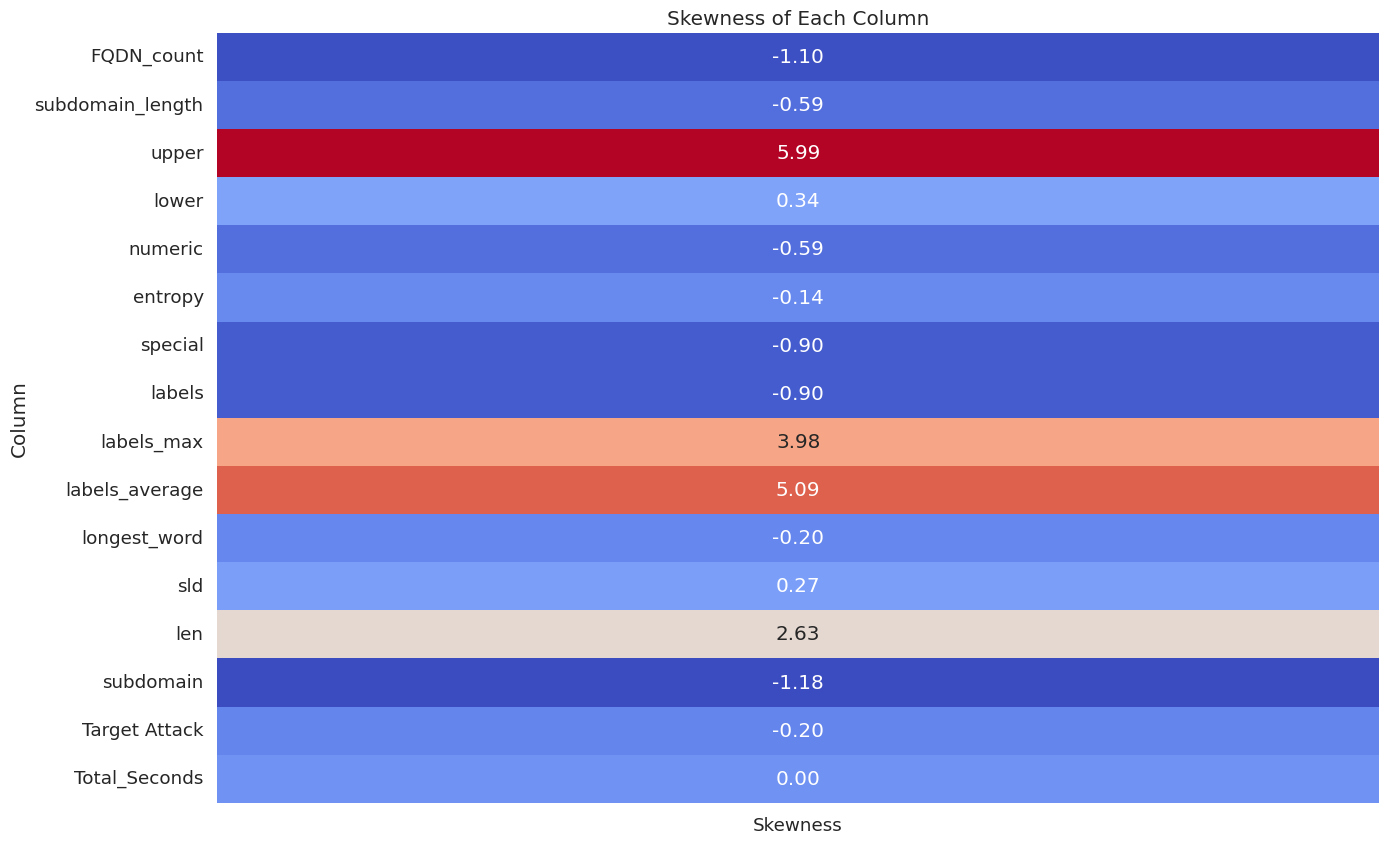

In [12]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.2)
sns.heatmap(df.skew().to_frame('Skewness'), cmap='coolwarm', annot=True, fmt=".2f", cbar=False)
plt.title('Skewness of Each Column')
plt.ylabel('Column')
plt.savefig('data_skew_plot.png')
plt.show()

# Get 4 columns with highest skew values

In [13]:
absolute_skew_values = df.skew().abs()
n_columns = 4
columns_with_highest_skew = absolute_skew_values.nlargest(n_columns).index
print(f"The {n_columns} columns with the highest absolute skew values are:")
print(columns_with_highest_skew)

The 4 columns with the highest absolute skew values are:
Index(['upper', 'labels_average', 'labels_max', 'len'], dtype='object')


# Apply log transform to remove the skewness

In [14]:
import numpy as np
for col in columns_with_highest_skew:
    df[col] = np.log1p(df[col])

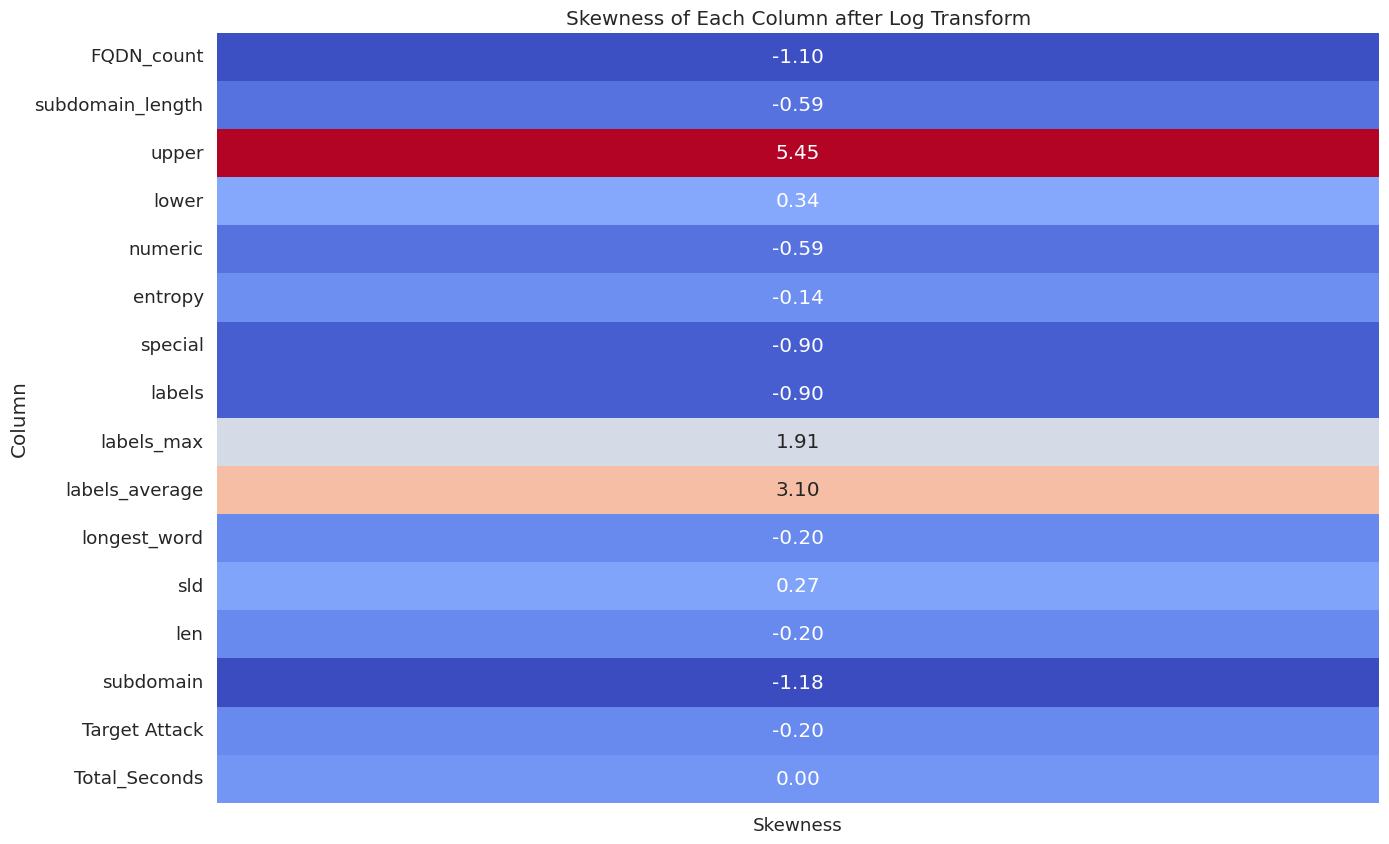

In [15]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.2)
sns.heatmap(df.skew().to_frame('Skewness'), cmap='coolwarm', annot=True, fmt=".2f", cbar=False)
plt.title('Skewness of Each Column after Log Transform')
plt.ylabel('Column')
plt.savefig('data_skew_plot_after.png')
plt.show()

# Plot the data after the Preprocessing

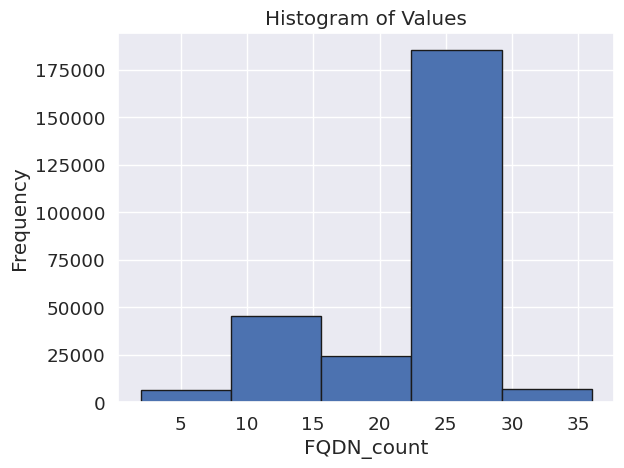

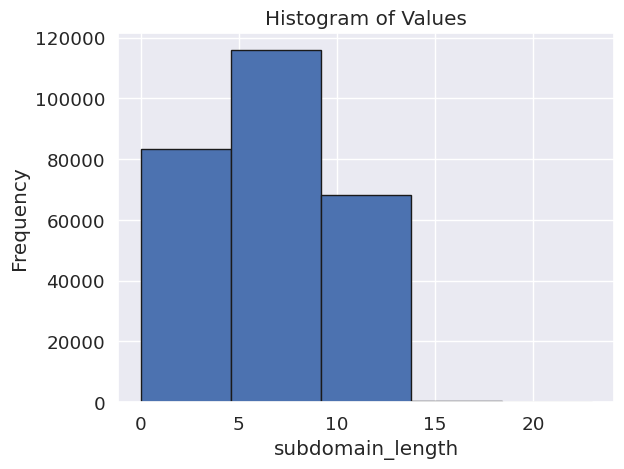

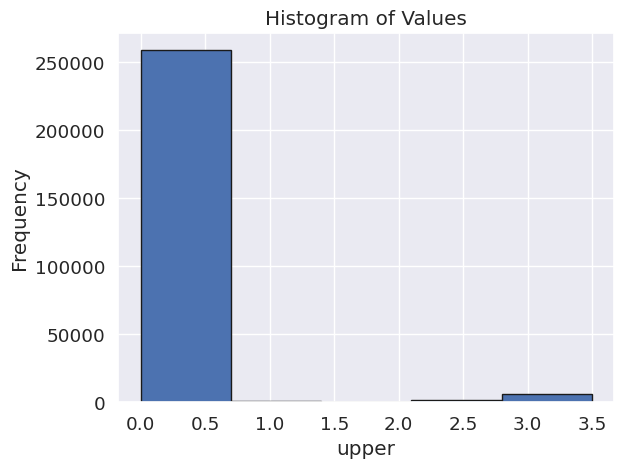

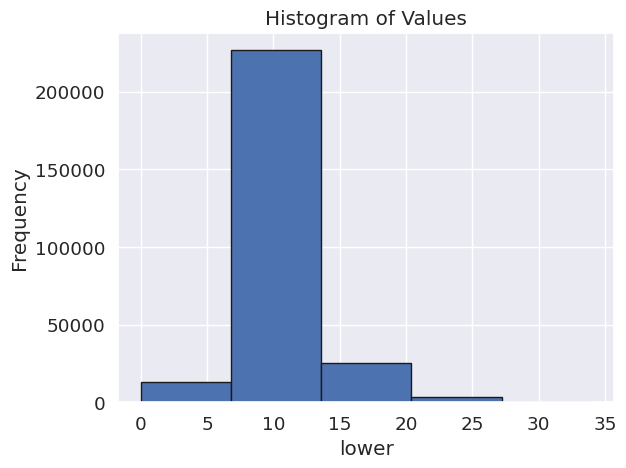

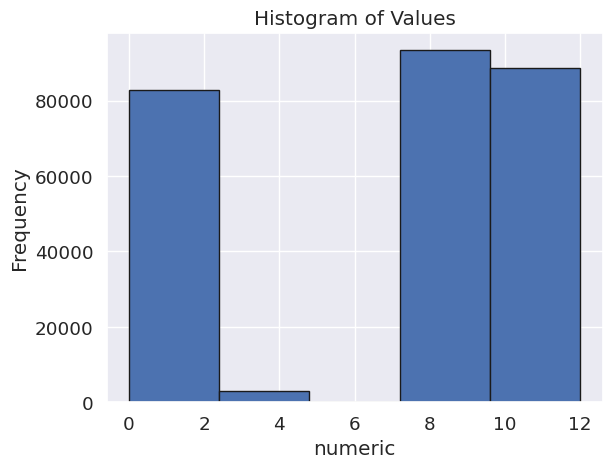

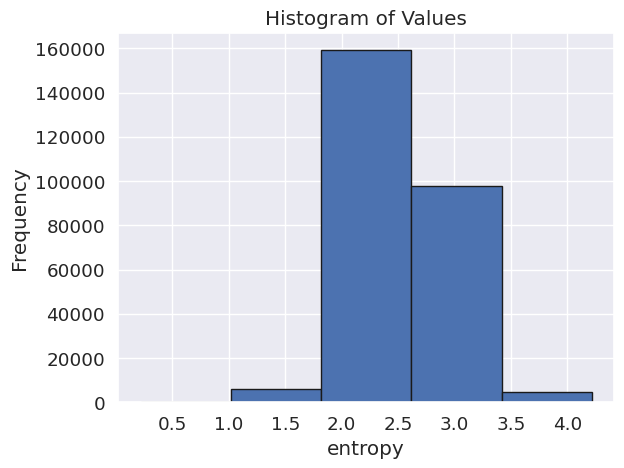

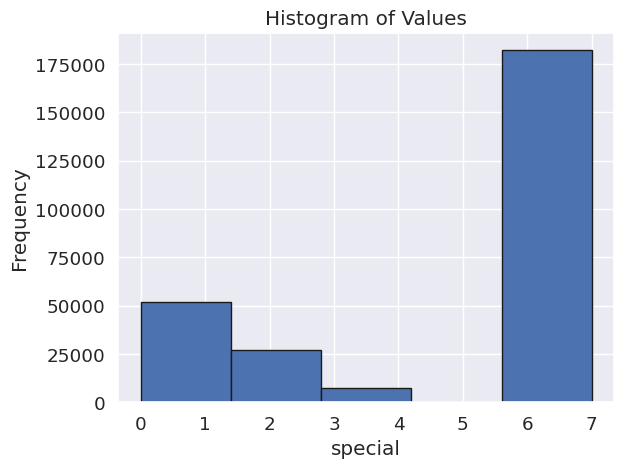

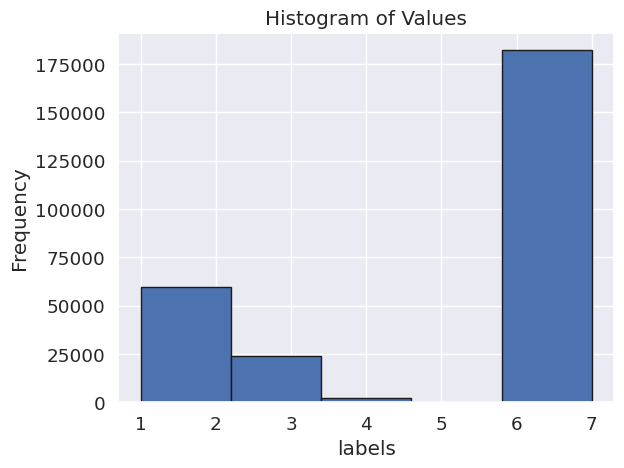

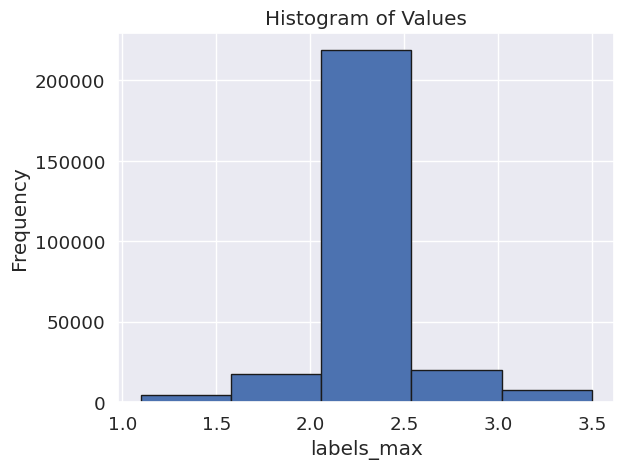

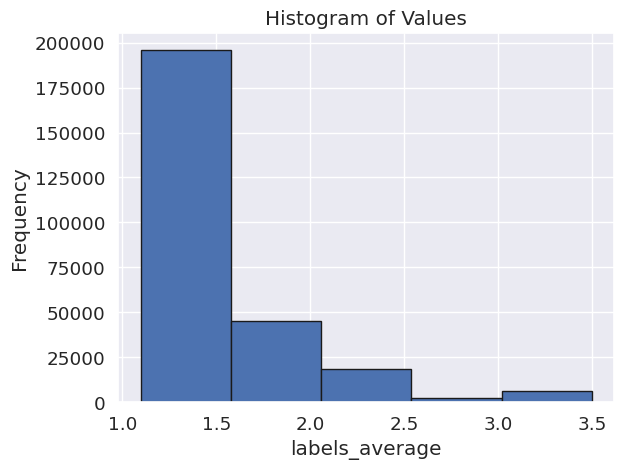

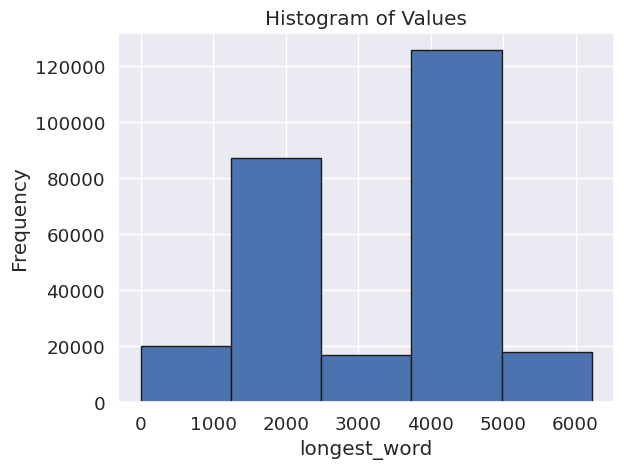

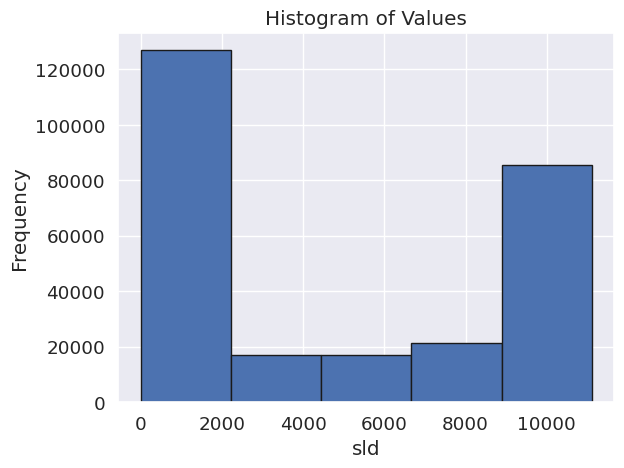

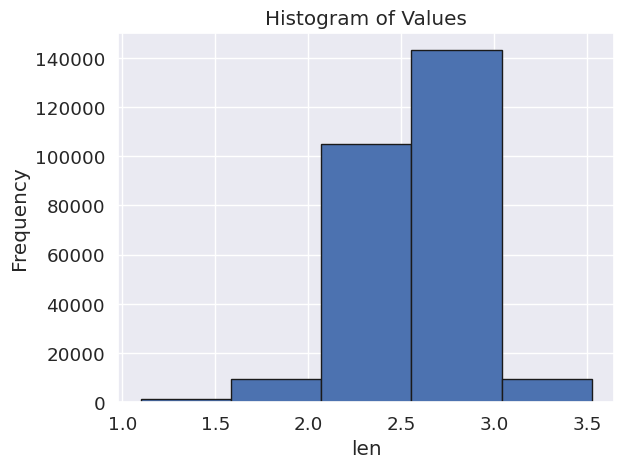

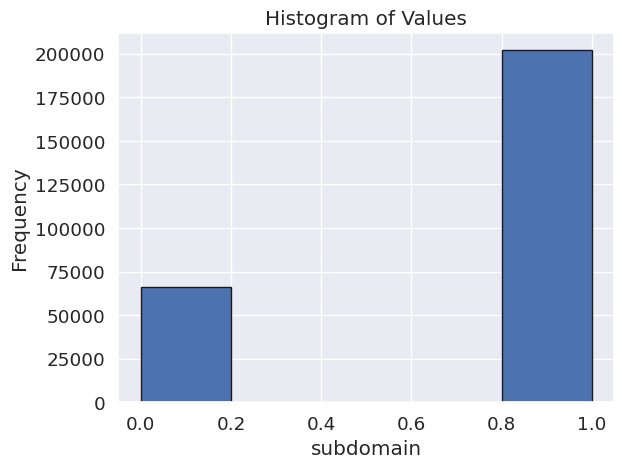

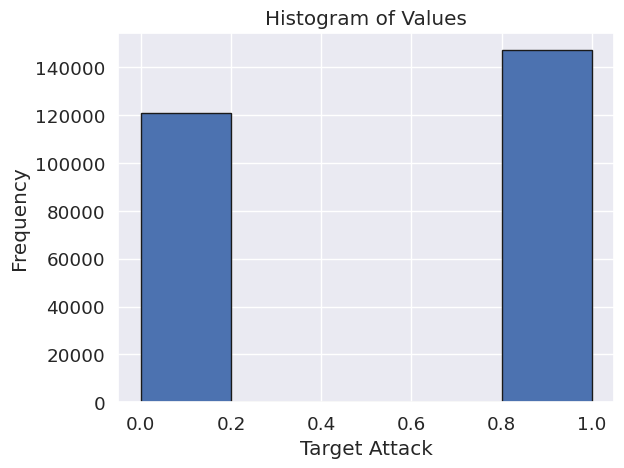

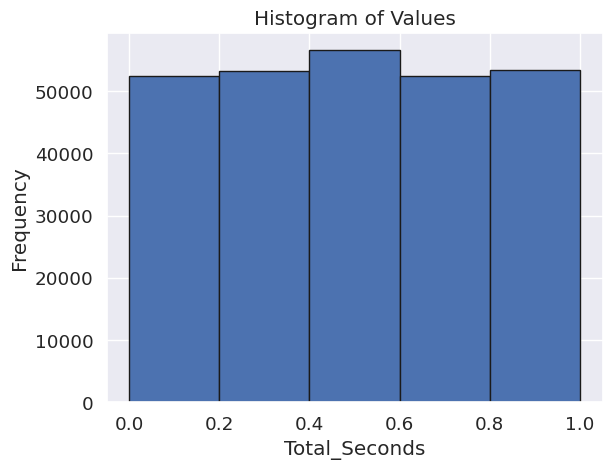

In [16]:

for col in df.columns:
    plt.hist(df[col], bins=5, edgecolor='k')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of Values')
    plt.show()


# Missing Values

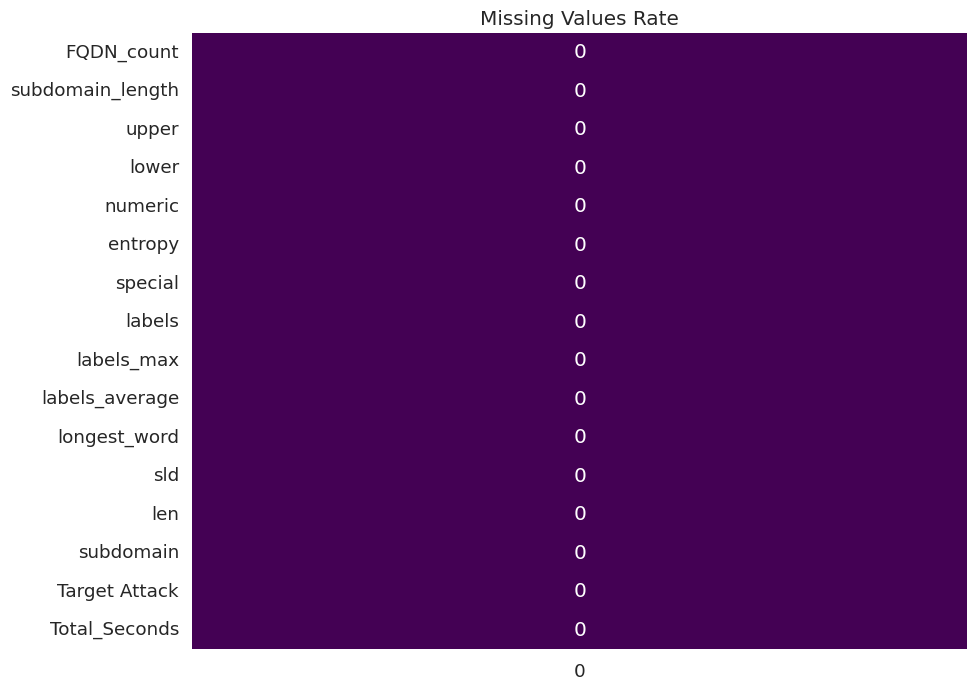

In [17]:
missing_values = df.isnull().sum()

plt.figure(figsize=(10, 8))
sns.heatmap(missing_values.to_frame(), cmap='viridis', annot=True, cbar=False)
plt.title('Missing Values Rate')
plt.savefig('Missing Values Rate.png')
plt.show()

# Calculate the Correlation between Features for Feature Selection

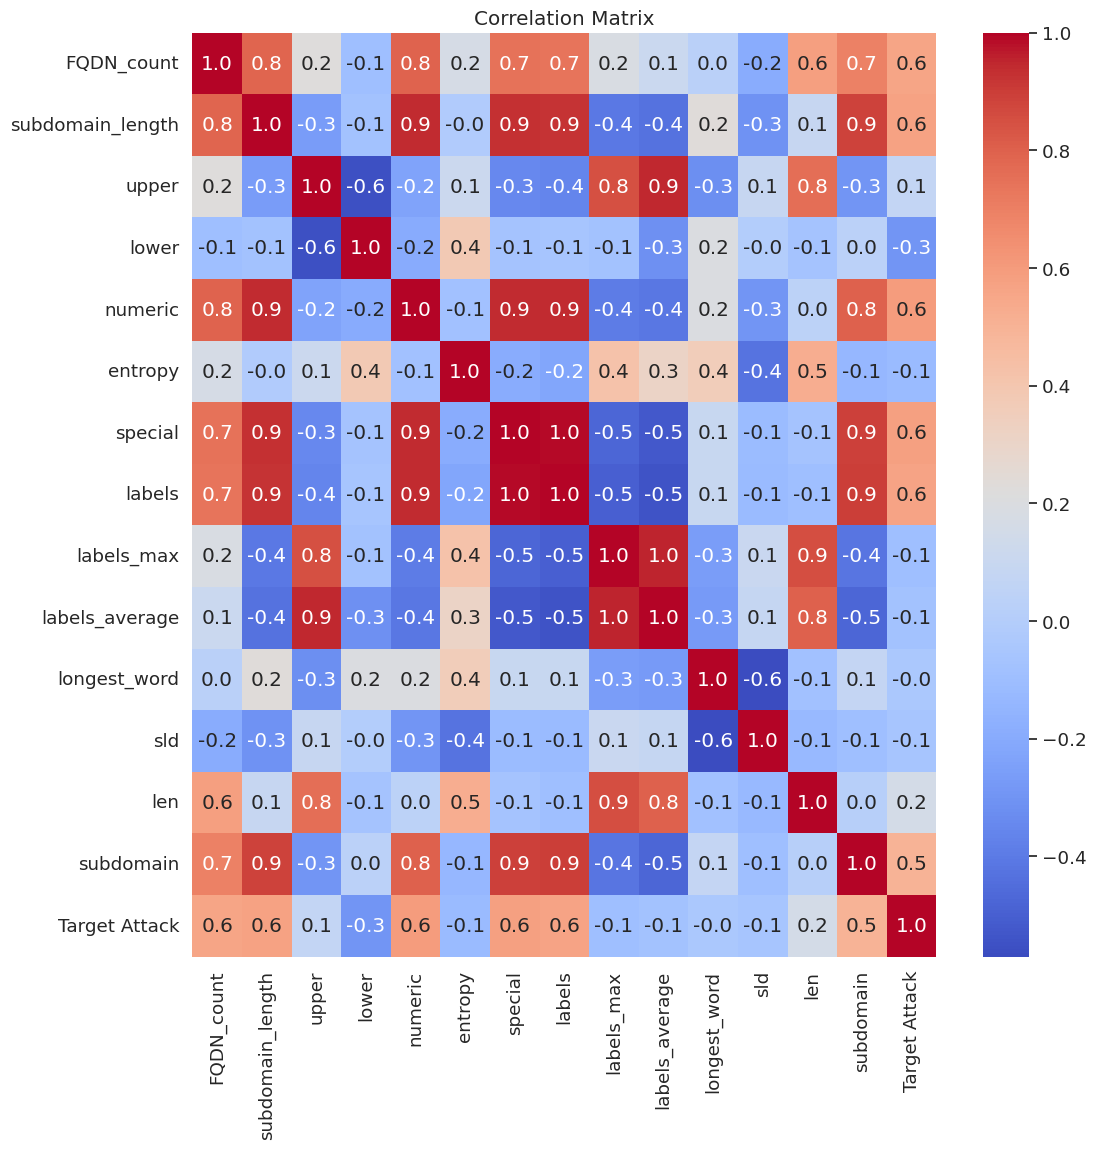

In [86]:
corr_matrix = normalize_data(df).corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True,fmt=".1f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('Correlation Matrix.png')
plt.show()

# Calculate Mutual Info Classification for Feauture Selection

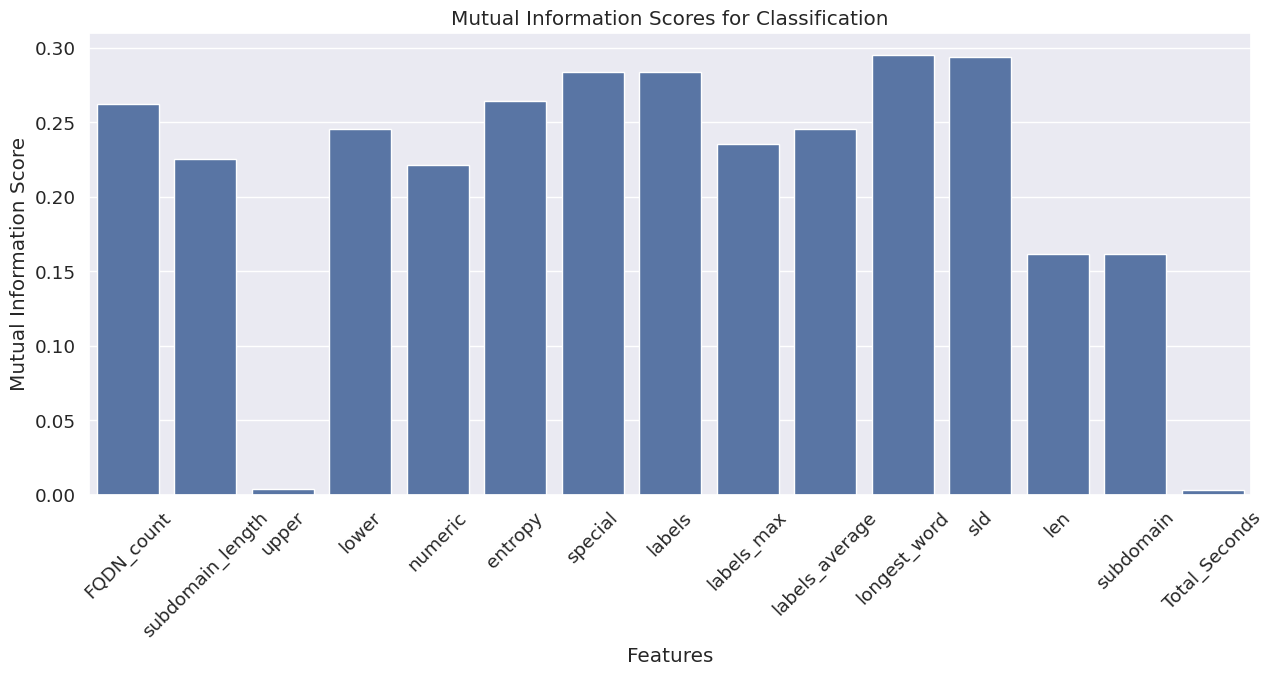

In [19]:
#split data to test and train
y = df["Target Attack"]
X = df.drop("Target Attack", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)


mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_train_mi = mi_selector.fit_transform(X_train, y_train)
mi_scores = mi_selector.scores_

plt.figure(figsize=(15, 6))
sns.barplot(x=X.columns, y=mi_scores)

plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Classification')
plt.xticks(rotation=45)
plt.savefig('data_mi.png')
plt.show()

# Hyper Parameter Tuning

In [ ]:
def find_best_model(model, param_grid, X_train, y_train):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score, average='binary')
    grid_search = GridSearchCV(model, param_grid, cv=k_fold, scoring=scorer)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    return best_model, best_params

# Normalizing 

In [ ]:
def normalize_data(df):
    scaler = MinMaxScaler()
    column_names = df.columns.tolist()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=column_names)
    return df_normalized

In [49]:
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

#calculate the correlation between features
correlation_selector = SelectKBest(score_func=f_classif, k= 12)
X_train_corr = correlation_selector.fit_transform(X_train, y_train)
selected_features_corr = X.columns[correlation_selector.get_support()]

#calculate the mutual info between features
mi_selector = SelectKBest(score_func=mutual_info_classif, k= 12)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
selected_features_mi = X.columns[mi_selector.get_support()]

#define grid for XGBoost hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


#define grids for random forest hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#find the best hyperparameters
rf_model = RandomForestClassifier(random_state=42)
best_model_rf_corr, best_params_rf_corr = find_best_model(rf_model, param_grid_rf, X_train_corr, y_train)
best_model_rf_mi, best_params_rf_mi = find_best_model(rf_model, param_grid_rf, X_train_mi, y_train)

#find the best hyperparameters
xgb_model = xgb.XGBClassifier()
best_model_xgb_corr, best_params_xgb_corr = find_best_model(xgb_model, param_grid_xgb, X_train_corr, y_train)
best_model_xgb_mi, best_params_xgb_mi = find_best_model(xgb_model, param_grid_xgb, X_train_mi, y_train)


#evaluate the models on the test set
y_pred_rf_corr = best_model_rf_corr.predict(X_test[selected_features_corr])
f1_score_rf_corr = f1_score(y_test, y_pred_rf_corr)
precision_rf_corr = precision_score(y_test, y_pred_rf_corr)
recall_rf_corr = recall_score(y_test, y_pred_rf_corr)

y_pred_rf_mi = best_model_rf_mi.predict(X_test[selected_features_mi])
f1_score_rf_mi = f1_score(y_test, y_pred_rf_mi)
precision_rf_mi = precision_score(y_test, y_pred_rf_mi)
recall_rf_mi = recall_score(y_test, y_pred_rf_mi)

y_pred_xgb_corr = best_model_xgb_corr.predict(X_test[selected_features_corr])
f1_score_xgb_corr = f1_score(y_test, y_pred_xgb_corr)
precision_xgb_corr = precision_score(y_test, y_pred_xgb_corr)
recall_xgb_corr = recall_score(y_test, y_pred_xgb_corr)

y_pred_xgb_mi = best_model_xgb_mi.predict(X_test[selected_features_mi])
f1_score_xgb_mi = f1_score(y_test, y_pred_xgb_mi)
precision_xgb_mi = precision_score(y_test, y_pred_xgb_mi)
recall_xgb_mi = recall_score(y_test, y_pred_xgb_mi)


Selected features using correlation coefficient: Index(['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
       'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len',
       'subdomain'],
      dtype='object')
Selected features using correlation coefficient: Index(['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'entropy',
       'special', 'labels', 'labels_max', 'labels_average', 'longest_word',
       'sld', 'subdomain'],
      dtype='object')
Best Hyperparameters (Correlation): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Hyperparameters (Correlation): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Hyperparameters (Correlation): {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Best Hyperparameters (Correlation): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsampl

In [76]:
print("RF Results:")
print("Selected features using correlation coefficient:", selected_features_corr)
print("Best Hyperparameters (Correlation):", best_params_rf_corr)
print("Model F1-score (Correlation):", f1_score_rf_corr)
print("Model Precision (Correlation):", precision_rf_corr)
print("Model Recall (Correlation):", recall_rf_corr)

print("\nSelected features using mutual information:", selected_features_mi)
print("Best Hyperparameters (Mutual Information):", best_params_rf_mi)
print("Model F1-score (Mutual Information):", f1_score_rf_mi)
print("Model Precision (Correlation):", precision_rf_mi)
print("Model Recall (Correlation):", recall_rf_mi)


print("XGB Results:")
print("Selected features using correlation coefficient:", selected_features_corr)
print("Best Hyperparameters (Correlation):", best_params_xgb_corr)
print("Model F1-score (Correlation):", f1_score_xgb_corr)
print("Model Precision (Correlation):", precision_xgb_corr)
print("Model Recall (Correlation):", recall_xgb_corr)

print("\nSelected features using mutual information:", selected_features_mi)
print("Best Hyperparameters (Mutual Information):", best_params_xgb_mi)
print("Model F1-score (Mutual Information):", f1_score_xgb_mi)
print("Model Precision (Correlation):", precision_xgb_mi)
print("Model Recall (Correlation):", recall_xgb_mi)

RF Results:
Selected features using correlation coefficient: Index(['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
       'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len',
       'subdomain'],
      dtype='object')
Best Hyperparameters (Correlation): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Model F1-score (Correlation): 0.8639858854664411
Model Precision (Correlation): 0.7607384201123683
Model Recall (Correlation): 0.9996597713663582

Selected features using mutual information: Index(['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'entropy',
       'special', 'labels', 'labels_max', 'labels_average', 'longest_word',
       'sld', 'subdomain'],
      dtype='object')
Best Hyperparameters (Mutual Information): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Model F1-score (Mutual Information): 0.8640359904731101
Model Precision (Correlation): 0.7607570030549371
Mo

# Apply cross validation with 5-fold to evaluate the models

In [ ]:
cv_results_xgb_corr = cross_val_score(best_model_xgb_corr, X_train, y_train, cv=5, scoring='f1')
cv_results_xgb_mi = cross_val_score(best_model_xgb_mi, X_train, y_train, cv=5, scoring='f1')

cv_results_rf_corr = cross_val_score(best_model_rf_corr, X_train, y_train, cv=5, scoring='f1')
cv_results_rf_mi = cross_val_score(best_model_rf_mi, X_train, y_train, cv=5, scoring='f1')

cv_results_xgb_corr_r = cross_val_score(best_model_xgb_corr, X_train, y_train, cv=5, scoring='recall')
cv_results_xgb_mi_r = cross_val_score(best_model_xgb_mi, X_train, y_train, cv=5, scoring='recall')

cv_results_rf_corr_r = cross_val_score(best_model_rf_corr, X_train, y_train, cv=5, scoring='recall')
cv_results_rf_mi_r = cross_val_score(best_model_rf_mi, X_train, y_train, cv=5, scoring='recall')

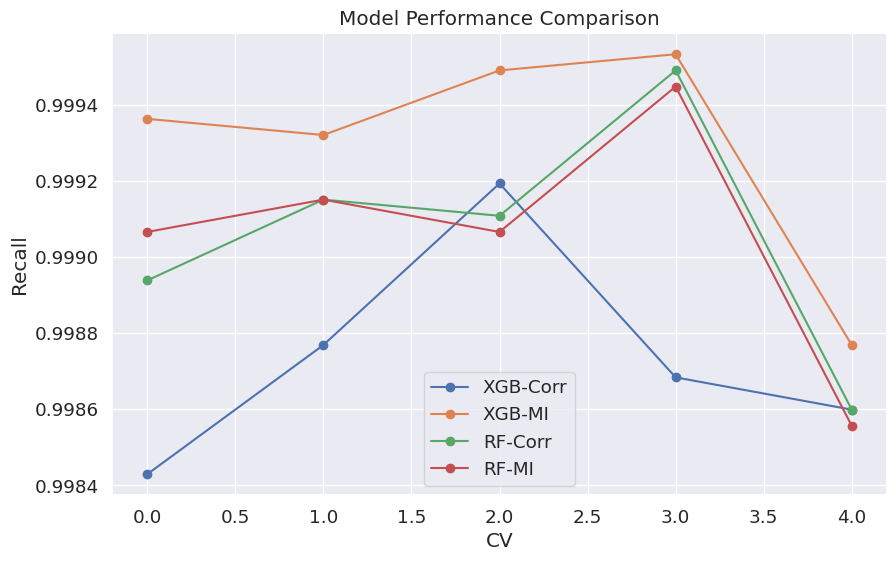

In [77]:
plt.figure(figsize=(10, 6))

plt.plot(cv_results_xgb_corr_r, label='XGB-Corr', marker='o')
plt.plot(cv_results_xgb_mi_r, label='XGB-MI', marker='o')
plt.plot(cv_results_rf_corr_r, label='RF-Corr', marker='o')
plt.plot(cv_results_rf_mi_r, label='RF-MI', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('CV')
plt.ylabel('Recall')
plt.legend()
plt.savefig('Model Performance Comparison - recall.png')
plt.show()

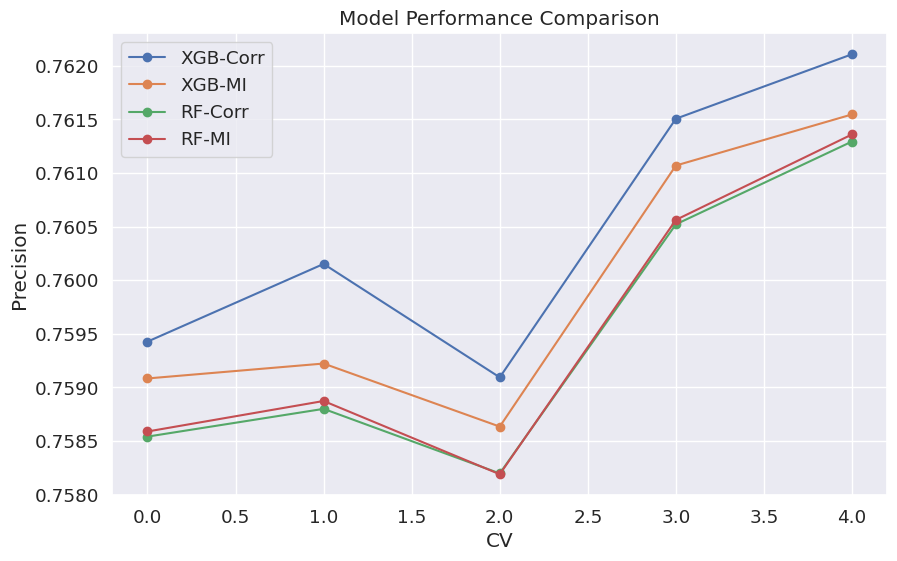

In [64]:
cv_results_xgb_corr_p = cross_val_score(best_model_xgb_corr, X_train, y_train, cv=5, scoring='precision')
cv_results_xgb_mi_p = cross_val_score(best_model_xgb_mi, X_train, y_train, cv=5, scoring='precision')

cv_results_rf_corr_p = cross_val_score(best_model_rf_corr, X_train, y_train, cv=5, scoring='precision')
cv_results_rf_mi_p = cross_val_score(best_model_rf_mi, X_train, y_train, cv=5, scoring='precision')

plt.figure(figsize=(10, 6))

plt.plot(cv_results_xgb_corr_p, label='XGB-Corr', marker='o')
plt.plot(cv_results_xgb_mi_p, label='XGB-MI', marker='o')
plt.plot(cv_results_rf_corr_p, label='RF-Corr', marker='o')
plt.plot(cv_results_rf_mi_p, label='RF-MI', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('CV')
plt.ylabel('Precision')
plt.legend()
plt.savefig('Model Performance Comparison.png')
plt.show()

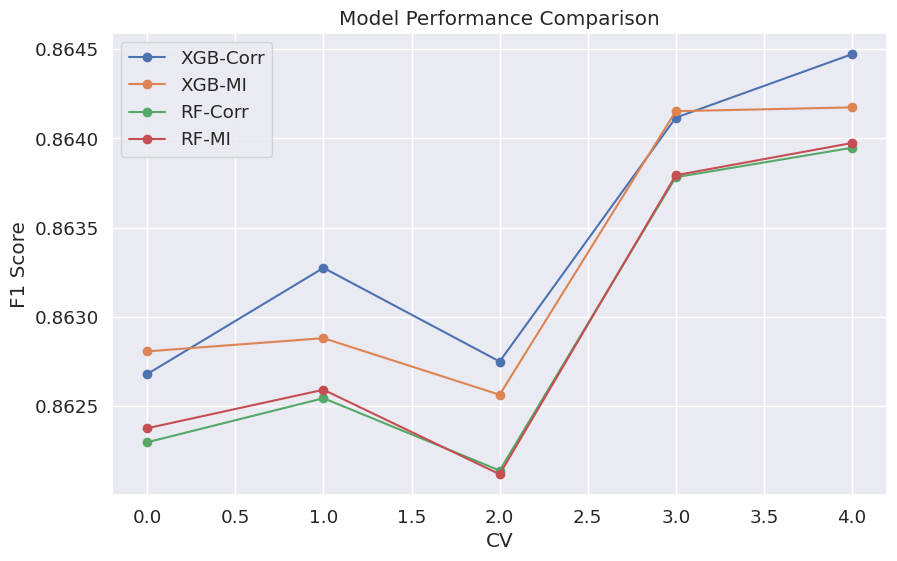

In [67]:
plt.figure(figsize=(10, 6))

plt.plot(cv_results_xgb_corr, label='XGB-Corr', marker='o')
plt.plot(cv_results_xgb_mi, label='XGB-MI', marker='o')
plt.plot(cv_results_rf_corr, label='RF-Corr', marker='o')
plt.plot(cv_results_rf_mi, label='RF-MI', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('CV')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('Model Performance Comparison - f1score.png')
plt.show()

# Saving the model

In [81]:
with open('best_model_xgb_corr.pkl', 'wb') as f:
    pickle.dump(best_model_xgb_corr, f)